<img src="images/seattle.jpg">

# King County House Sales Analysis
Author: Jennifer Ha
***

## Overview 
This project analyzes house sales data in King County in Seattle from 2014-2015, which consists of ~21,600 transactions. Through some exploratory data analyses and iterative regression models, we will identify some features that have the strongest relationship with price.. The result shows that the model with feature engineering was the best-performing model, also revealing that waterfront properties, more viewings to potential buyers, and higher grading using King County grading system have the biggest impact on house prices.

## Business Problem
Star Real Estate Agency (imaginary real estate company in Seattle) is seeking advice to close deals with higher housing sales prices. In this project, we are providing analysis on which features can bring more monetary value as well as strategy. We are also creating a model to estimate the price of a home when those criterias are met. Questions to consider:
* Is a waterfront property worth more than an inland property?
* Does the number of viewings to potential buyers affect the housing price?
* Does the King County grading system affect the housing price?

## Data
The dataset consists of ~21,600 rows of real estate transactions from King County, Seattle (WA) from 2014-2015. The columns represent different features associated with each property, which are outlined below. The target variable is the price of the property, which will be used in our models to determine the winning model, along with features that have strong relationships with it.

Prior to iterating regression models and predictions, I conducted some exploratory data analyses to clean up the data using IQR method to prepare it for modeling, and went through several iterations to refine the model.

### Columns
* `id`: uniques identifier for a house
* `date`: date the house was sold
* `price`: prediction target
* `bedrooms`: number of bedrooms
* `bathrooms`: number of bathrooms
* `sqft_living`: square foot living space
* `sqft_lot`: square foot of lot
* `floors`: number of floors
* `waterfront`: house which has a view to a waterfront
* `view`: number of viewings
* `condition`: how good the condition is (overall)
* `grade`: overall grade given to the housing unit, based on King County grading system
* `sqft_above`: square footage of house apart from basement
* `sqft_basement`: square footage of the basement
* `yr_built`: Built Year
* `yr_renovated`: Year when house was renovated
* `zipcode`: zip
* `lat`: Latitude coordinate
* `long`: Longitude coordinate
* `sqft_living15`: The square footage of interior housing living space for the nearest 15 neighbors
* `sqft_lot15`: The square footage of the land lots of the nearest 15 neighbors

***

### Data Preparation & Clean Up

In [1]:
# Import all libraries & packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression,Ridge
import pylab
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.preprocessing import OneHotEncoder

from matplotlib.gridspec import GridSpec

import scipy.stats as stats
from statsmodels.formula.api import ols

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

%matplotlib inline

# Import my personal functions 
from functions import linear_model

# Remove scientific notation
pd.options.display.float_format = '{:,.5f}'.format

# Display all the columns without truncation
pd.set_option('display.max_columns', None)

# Import data into a dataframe and preview 
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,"221,900.00000",3,1.00000,1180,5650,1.00000,nan,0.00000,3,7,1180,0.0,1955,0.00000,98178,47.51120,-122.25700,1340,5650
1,6414100192,12/9/2014,"538,000.00000",3,2.25000,2570,7242,2.00000,0.00000,0.00000,3,7,2170,400.0,1951,"1,991.00000",98125,47.72100,-122.31900,1690,7639
2,5631500400,2/25/2015,"180,000.00000",2,1.00000,770,10000,1.00000,0.00000,0.00000,3,6,770,0.0,1933,nan,98028,47.73790,-122.23300,2720,8062
3,2487200875,12/9/2014,"604,000.00000",4,3.00000,1960,5000,1.00000,0.00000,0.00000,5,7,1050,910.0,1965,0.00000,98136,47.52080,-122.39300,1360,5000
4,1954400510,2/18/2015,"510,000.00000",3,2.00000,1680,8080,1.00000,0.00000,0.00000,3,8,1680,0.0,1987,0.00000,98074,47.61680,-122.04500,1800,7503


In [2]:
# Get summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

### Check for Duplicates
We want the `id` column to work an index to represent each transaction rather than each property. Let's take a look at the duplicates for houses that were sold more than once.

In [3]:
# Check for duplicates in 'id' which should work as index
df.id.duplicated().sum()

177

In [4]:
# Create a separate table to examine the duplicates
df_id_duplicates = df[df.duplicated('id')]

df_id_duplicates

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
94,6021501535,12/23/2014,"700,000.00000",3,1.50000,1580,5000,1.00000,0.00000,0.00000,3,8,1290,290.0,1939,0.00000,98117,47.68700,-122.38600,1570,4500
314,4139480200,12/9/2014,"1,400,000.00000",4,3.25000,4290,12103,1.00000,0.00000,3.00000,3,11,2690,1600.0,1997,0.00000,98006,47.55030,-122.10200,3860,11244
325,7520000520,3/11/2015,"240,500.00000",2,1.00000,1240,12092,1.00000,0.00000,0.00000,3,6,960,280.0,1922,"1,984.00000",98146,47.49570,-122.35200,1820,7460
346,3969300030,12/29/2014,"239,900.00000",4,1.00000,1000,7134,1.00000,0.00000,0.00000,3,6,1000,0.0,1943,nan,98178,47.48970,-122.24000,1020,7138
372,2231500030,3/24/2015,"530,000.00000",4,2.25000,2180,10754,1.00000,0.00000,0.00000,5,7,1100,1080.0,1954,0.00000,98133,47.77110,-122.34100,1810,6929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20165,7853400250,2/19/2015,"645,000.00000",4,3.50000,2910,5260,2.00000,0.00000,0.00000,3,9,2910,0.0,2012,0.00000,98065,47.51680,-121.88300,2910,5260
20597,2724049222,12/1/2014,"220,000.00000",2,2.50000,1000,1092,2.00000,0.00000,0.00000,3,7,990,10.0,2004,0.00000,98118,47.54190,-122.27100,1330,1466
20654,8564860270,3/30/2015,"502,000.00000",4,2.50000,2680,5539,2.00000,nan,0.00000,3,8,2680,0.0,2013,0.00000,98045,47.47590,-121.73400,2680,5992
20764,6300000226,5/4/2015,"380,000.00000",4,1.00000,1200,2171,1.50000,0.00000,0.00000,3,7,1200,0.0,1933,0.00000,98133,47.70760,-122.34200,1130,1598


In [5]:
# Spot check data
df.loc[df['id'] == 6021501535]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
93,6021501535,7/25/2014,"430,000.00000",3,1.50000,1580,5000,1.00000,0.00000,0.00000,3,8,1290,290.0,1939,0.00000,98117,47.68700,-122.38600,1570,4500
94,6021501535,12/23/2014,"700,000.00000",3,1.50000,1580,5000,1.00000,0.00000,0.00000,3,8,1290,290.0,1939,0.00000,98117,47.68700,-122.38600,1570,4500


In [6]:
# Spot check data
df.loc[df['id'] == 3969300030]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
345,3969300030,7/23/2014,"165,000.00000",4,1.00000,1000,7134,1.00000,0.00000,0.00000,3,6,1000,0.0,1943,0.00000,98178,47.48970,-122.24000,1020,7138
346,3969300030,12/29/2014,"239,900.00000",4,1.00000,1000,7134,1.00000,0.00000,0.00000,3,6,1000,0.0,1943,nan,98178,47.48970,-122.24000,1020,7138


In [7]:
# Spot check data
df.loc[df['id'] == 6300000226]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
20763,6300000226,6/26/2014,"240,000.00000",4,1.00000,1200,2171,1.50000,0.00000,0.00000,3,7,1200,0.0,1933,0.00000,98133,47.70760,-122.34200,1130,1598
20764,6300000226,5/4/2015,"380,000.00000",4,1.00000,1200,2171,1.50000,0.00000,0.00000,3,7,1200,0.0,1933,0.00000,98133,47.70760,-122.34200,1130,1598


I'm going to keep the latest transaction only since we are not interested in historical transaction data.

In [8]:
# Drop the historical data
df.drop_duplicates(subset= 'id', keep= 'last', inplace= True)

In [9]:
# Check if the duplicates are removed
df.id.duplicated().sum()

0

### Remove `Date`
Drop `date` column as it won't be needed for this project.

In [10]:
df.drop(['date'], axis= 1, inplace= True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21420 non-null  int64  
 1   price          21420 non-null  float64
 2   bedrooms       21420 non-null  int64  
 3   bathrooms      21420 non-null  float64
 4   sqft_living    21420 non-null  int64  
 5   sqft_lot       21420 non-null  int64  
 6   floors         21420 non-null  float64
 7   waterfront     19067 non-null  float64
 8   view           21357 non-null  float64
 9   condition      21420 non-null  int64  
 10  grade          21420 non-null  int64  
 11  sqft_above     21420 non-null  int64  
 12  sqft_basement  21420 non-null  object 
 13  yr_built       21420 non-null  int64  
 14  yr_renovated   17607 non-null  float64
 15  zipcode        21420 non-null  int64  
 16  lat            21420 non-null  float64
 17  long           21420 non-null  float64
 18  sqft_l

### Integer - sqft_basement
The `sqft_basement` column is an object where as the values are showing up as float. Let's take a look at this column.

In [12]:
# Check why sqft_basement is an object and not an integer
df.sqft_basement.value_counts()

0.0       12716
?           452
600.0       216
500.0       206
700.0       206
          ...  
3500.0        1
2610.0        1
2196.0        1
415.0         1
2580.0        1
Name: sqft_basement, Length: 304, dtype: int64

The `sqft_basement` column contains '?' which appears to be missing values. Let's replace them with '0' as we are unable to track down this information.

In [13]:
# Replace '?' in sqft_basement to 0 since they are unidentifiable
df['sqft_basement'] = df['sqft_basement'].replace('?', '0.0')

df.sqft_basement.value_counts()

0.0       13168
600.0       216
700.0       206
500.0       206
800.0       201
          ...  
3500.0        1
2610.0        1
2196.0        1
415.0         1
2580.0        1
Name: sqft_basement, Length: 303, dtype: int64

Now that all values are numerical, let's change the data type to 'float'.

In [14]:
# Change data type of basement to float instead of object
df['sqft_basement'] = df.sqft_basement.astype('float')

For this project, we are interested in whether a property has a basement rather than how big the basement is. Therefore, let's replace the basement size for each property with '1' to indicate that the property has a basement.

In [15]:
# Replace values with 1 to indicate that the property has a basement
df.loc[df['sqft_basement'] > 0, 'sqft_basement'] = 1

In [16]:
# Rename the column to 'basement_yn'
df = df.rename(columns={"sqft_basement":"basement_yn"})

In [17]:
# Check the DataFrame
df

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,basement_yn,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,"221,900.00000",3,1.00000,1180,5650,1.00000,nan,0.00000,3,7,1180,0.00000,1955,0.00000,98178,47.51120,-122.25700,1340,5650
1,6414100192,"538,000.00000",3,2.25000,2570,7242,2.00000,0.00000,0.00000,3,7,2170,1.00000,1951,"1,991.00000",98125,47.72100,-122.31900,1690,7639
2,5631500400,"180,000.00000",2,1.00000,770,10000,1.00000,0.00000,0.00000,3,6,770,0.00000,1933,nan,98028,47.73790,-122.23300,2720,8062
3,2487200875,"604,000.00000",4,3.00000,1960,5000,1.00000,0.00000,0.00000,5,7,1050,1.00000,1965,0.00000,98136,47.52080,-122.39300,1360,5000
4,1954400510,"510,000.00000",3,2.00000,1680,8080,1.00000,0.00000,0.00000,3,8,1680,0.00000,1987,0.00000,98074,47.61680,-122.04500,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,"360,000.00000",3,2.50000,1530,1131,3.00000,0.00000,0.00000,3,8,1530,0.00000,2009,0.00000,98103,47.69930,-122.34600,1530,1509
21593,6600060120,"400,000.00000",4,2.50000,2310,5813,2.00000,0.00000,0.00000,3,8,2310,0.00000,2014,0.00000,98146,47.51070,-122.36200,1830,7200
21594,1523300141,"402,101.00000",2,0.75000,1020,1350,2.00000,0.00000,0.00000,3,7,1020,0.00000,2009,0.00000,98144,47.59440,-122.29900,1020,2007
21595,291310100,"400,000.00000",3,2.50000,1600,2388,2.00000,nan,0.00000,3,8,1600,0.00000,2004,0.00000,98027,47.53450,-122.06900,1410,1287


### Null Values
We have identified that `waterfront`, `view`, and `yr_renovated` columns have some missing values. Let's examine each of them and determine how we will proceed.

In [18]:
# Check 'waterfront'
df.waterfront.value_counts(normalize = False)

0.00000    18921
1.00000      146
Name: waterfront, dtype: int64

In [19]:
# Check 'view'
df.view.value_counts(normalize = True)

0.00000   0.90148
2.00000   0.04476
3.00000   0.02365
1.00000   0.01540
4.00000   0.01470
Name: view, dtype: float64

In [20]:
# Check 'yr_renovated'
df.yr_renovated.value_counts(normalize = True)

0.00000       0.95797
2,014.00000   0.00415
2,003.00000   0.00176
2,013.00000   0.00176
2,007.00000   0.00170
                ...  
1,934.00000   0.00006
1,971.00000   0.00006
1,954.00000   0.00006
1,950.00000   0.00006
1,944.00000   0.00006
Name: yr_renovated, Length: 70, dtype: float64

Above analysis shows that:
1. 99.2% of properties in the dataseet are not near the Seattle waterfront.
2. 90.1% of properties do not have a view. 
3. 95.8% of properties have not been renovated since it was built.

While having such large amount of null values can be problematic, it makes sense in this scenario.Therefore, we will simply replace those null values with zeros. 

In [21]:
# Replace null values with zeros
df.fillna(0, inplace= True)

Lastly, let's re-set the index.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21420 non-null  int64  
 1   price          21420 non-null  float64
 2   bedrooms       21420 non-null  int64  
 3   bathrooms      21420 non-null  float64
 4   sqft_living    21420 non-null  int64  
 5   sqft_lot       21420 non-null  int64  
 6   floors         21420 non-null  float64
 7   waterfront     21420 non-null  float64
 8   view           21420 non-null  float64
 9   condition      21420 non-null  int64  
 10  grade          21420 non-null  int64  
 11  sqft_above     21420 non-null  int64  
 12  basement_yn    21420 non-null  float64
 13  yr_built       21420 non-null  int64  
 14  yr_renovated   21420 non-null  float64
 15  zipcode        21420 non-null  int64  
 16  lat            21420 non-null  float64
 17  long           21420 non-null  float64
 18  sqft_l

For this exercise, we will focus on whether the property has been renovated rather than when it was renovated. Therefore, Let's replace the values with '1' if renovated, and keep '0' if not renovated.

In [23]:
df.loc[df['yr_renovated'] > 0, 'yr_renovated'] = 1

In [24]:
df = df.rename(columns={"yr_renovated":"renovated_yn"})

In [25]:
# Drop 'id' as we no longer need this column
df.drop(['id'], axis= 1, inplace= True)

### Outliers

let's visualize and check the distributions in each column and we will use IQR method to remove outliers.


In [26]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,basement_yn,yr_built,renovated_yn,zipcode,lat,long,sqft_living15,sqft_lot15
count,"21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000"
mean,"541,861.42815",3.37395,2.11843,"2,083.13263","15,128.03800",1.49599,0.00682,0.23399,3.41078,7.66279,"1,791.17021",0.38525,"1,971.09300",0.03455,"98,077.87437",47.56020,-122.21378,"1,988.38408","12,775.71816"
std,"367,556.93785",0.92540,0.76872,918.80841,"41,530.79684",0.54008,0.08228,0.76544,0.65004,1.17197,828.69296,0.48667,29.38714,0.18263,53.47748,0.13859,0.14079,685.53706,"27,345.62187"
min,"78,000.00000",1.00000,0.50000,370.00000,520.00000,1.00000,0.00000,0.00000,1.00000,3.00000,370.00000,0.00000,"1,900.00000",0.00000,"98,001.00000",47.15590,-122.51900,399.00000,651.00000
25%,"324,950.00000",3.00000,1.75000,"1,430.00000","5,040.00000",1.00000,0.00000,0.00000,3.00000,7.00000,"1,200.00000",0.00000,"1,952.00000",0.00000,"98,033.00000",47.47120,-122.32800,"1,490.00000","5,100.00000"
50%,"450,550.00000",3.00000,2.25000,"1,920.00000","7,614.00000",1.50000,0.00000,0.00000,3.00000,7.00000,"1,560.00000",0.00000,"1,975.00000",0.00000,"98,065.00000",47.57210,-122.23000,"1,840.00000","7,620.00000"
75%,"645,000.00000",4.00000,2.50000,"2,550.00000","10,690.50000",2.00000,0.00000,0.00000,4.00000,8.00000,"2,220.00000",1.00000,"1,997.00000",0.00000,"98,117.00000",47.67810,-122.12500,"2,370.00000","10,086.25000"
max,"7,700,000.00000",33.00000,8.00000,"13,540.00000","1,651,359.00000",3.50000,1.00000,4.00000,5.00000,13.00000,"9,410.00000",1.00000,"2,015.00000",1.00000,"98,199.00000",47.77760,-121.31500,"6,210.00000","871,200.00000"


In [27]:
col = df.columns
col

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'basement_yn',
       'yr_built', 'renovated_yn', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')

In [28]:
def plot_boxplots(df, col=None, boxplot=True):
    fig = plt.figure(figsize=(11, 6))
    gs = GridSpec(nrows=3, ncols=2)

    ax1 = fig.add_subplot(gs[1, 0])
    if col is None:
        data = df.copy()
        name = data.name
    else:
        data = df[col].copy()
        name = col

    ## Plot Boxplot
    sns.boxplot(data,x=col,ax=ax1)
    ax1.set_title(f'Box Plot of {name.title()}')

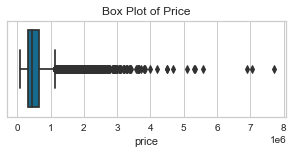

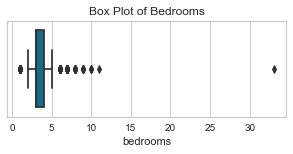

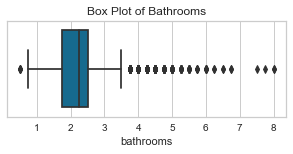

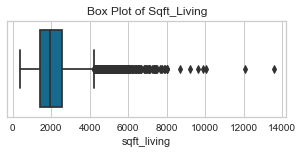

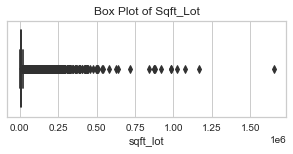

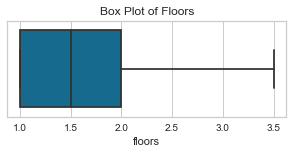

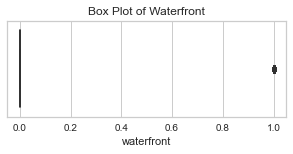

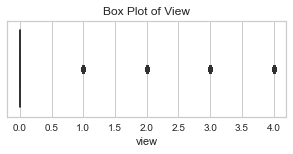

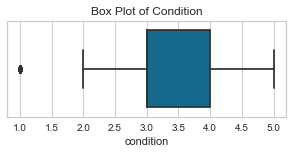

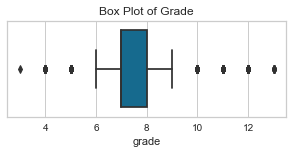

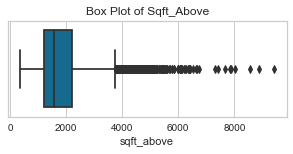

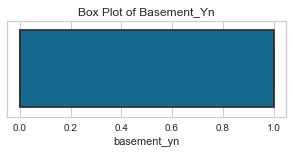

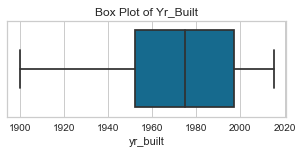

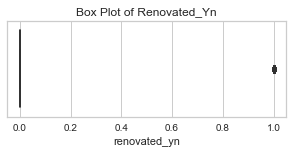

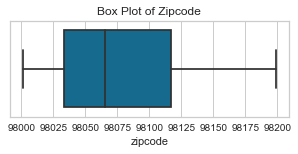

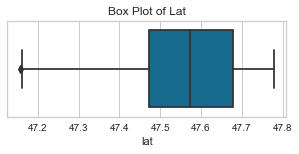

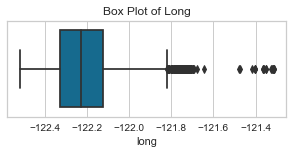

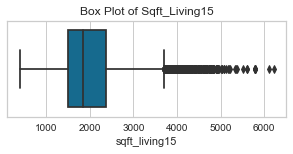

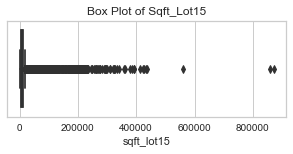

In [29]:
for col in df:
    plot_boxplots(df =df , col=col)

In [30]:
# Remove outliers using IQR method
# Code modified from https://stackoverflow.com/questions/50461349/how-to-remove-outlier-from-dataframe-using-iqr

def outlier_IQR(df):
    
    keep = df.describe()
    q1 = keep['25%']
    q3 = keep['75%']
    IQR = q3-q1
    outliers =(df < (q1- 1.5 * IQR)) | (df > (q3 + 1.5 * IQR))
    return outliers

In [31]:
# Create list of columns to remove outliers from
outliers_col = ['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above',
                'sqft_living15', 'sqft_lot15']
df1 = df.copy()

# Remove outliers for specified columns
for col in outliers_col:
    df1 = df1[~outlier_IQR(df1[col])]

In [32]:
df1

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,basement_yn,yr_built,renovated_yn,zipcode,lat,long,sqft_living15,sqft_lot15
0,"221,900.00000",3,1.00000,1180,5650,1.00000,0.00000,0.00000,3,7,1180,0.00000,1955,0.00000,98178,47.51120,-122.25700,1340,5650
1,"538,000.00000",3,2.25000,2570,7242,2.00000,0.00000,0.00000,3,7,2170,1.00000,1951,1.00000,98125,47.72100,-122.31900,1690,7639
2,"180,000.00000",2,1.00000,770,10000,1.00000,0.00000,0.00000,3,6,770,0.00000,1933,0.00000,98028,47.73790,-122.23300,2720,8062
3,"604,000.00000",4,3.00000,1960,5000,1.00000,0.00000,0.00000,5,7,1050,1.00000,1965,0.00000,98136,47.52080,-122.39300,1360,5000
4,"510,000.00000",3,2.00000,1680,8080,1.00000,0.00000,0.00000,3,8,1680,0.00000,1987,0.00000,98074,47.61680,-122.04500,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,"360,000.00000",3,2.50000,1530,1131,3.00000,0.00000,0.00000,3,8,1530,0.00000,2009,0.00000,98103,47.69930,-122.34600,1530,1509
21593,"400,000.00000",4,2.50000,2310,5813,2.00000,0.00000,0.00000,3,8,2310,0.00000,2014,0.00000,98146,47.51070,-122.36200,1830,7200
21594,"402,101.00000",2,0.75000,1020,1350,2.00000,0.00000,0.00000,3,7,1020,0.00000,2009,0.00000,98144,47.59440,-122.29900,1020,2007
21595,"400,000.00000",3,2.50000,1600,2388,2.00000,0.00000,0.00000,3,8,1600,0.00000,2004,0.00000,98027,47.53450,-122.06900,1410,1287


In [33]:
# Drop price to only show correlation between independent variables
corr = df1.drop('price', axis=1).corr().round(2)

In [34]:
# Create mask for upper triangle of matrix
mask = np.zeros_like(corr)

mask[np.triu_indices_from(mask)] = True

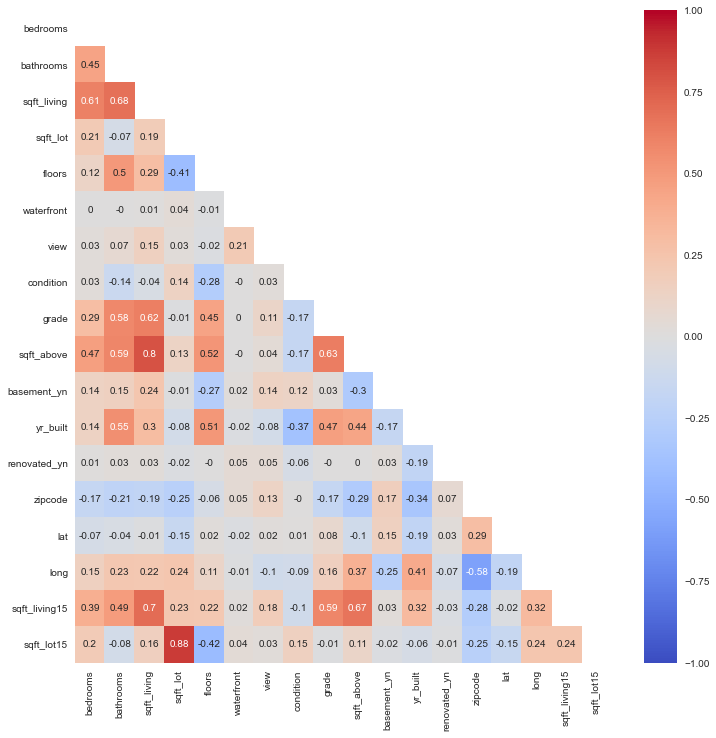

In [35]:
# Create heatmap correlation matrix
# https://medium.com/@chrisshaw982/seaborn-correlation-heatmaps-customized-10246f4f7f4b
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr, annot=True, ax=ax, cmap='coolwarm', vmin=-1, vmax=1,mask=mask);

## Exploratory Data Analysis (EDA)
Prior to creating and iterating regression models, we will run some EDA to help the real estate company identify which properties they prioritize to acquire in their listings.

### Question 1: Is a waterfront property worth more than an inland property?

First, let's take a look at how many waterfront properties were bought/sold in 2014-2015.

In [36]:
print(len(df1[df1['waterfront'] == 1]))

15


In [37]:
len(df1[df1['waterfront'] == 1]) / len(df)

0.0007002801120448179

After removing the outliers, there are only 15 waterfront properties remaining in the DataFrame. There were only 146 houses to begin with, which shows that waterfront properties are very rare in the market.

Let's calculate how much more a waterfront property would be worth on average.

In [38]:
df1.groupby('waterfront')['price'].mean().round(2)

waterfront
0.00000   452,199.75000
1.00000   796,196.67000
Name: price, dtype: float64

''

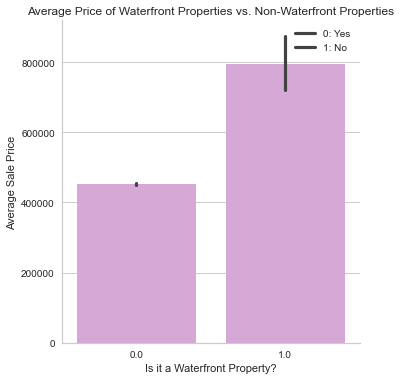

In [39]:
# Create a bar plot to visualize the difference
labels = ['0: Yes', '1: No']
sns.catplot(x="waterfront", y="price", kind="bar", data=df1, color= 'plum')
plt.title('Average Price of Waterfront Properties vs. Non-Waterfront Properties')
plt.xlabel('Is it a Waterfront Property?')
plt.ylabel('Average Sale Price')
plt.legend(labels= labels)
;

Waterfront properties are definitely in the real estate market but there are not a lot of them out there. I highly recommend securing waterfront properties whenever they are available since those can be worth $344,597 more on average than inland properties.

### Question 2: Does the number of viewings to potential buyers affect the housing price?

In [40]:
df1_v = df1.groupby('view')['price'].mean().round(2)
df1_v

view
0.00000   440,731.37000
1.00000   605,160.79000
2.00000   604,777.25000
3.00000   647,968.04000
4.00000   795,479.17000
Name: price, dtype: float64

Text(0.5, 0, 'View')

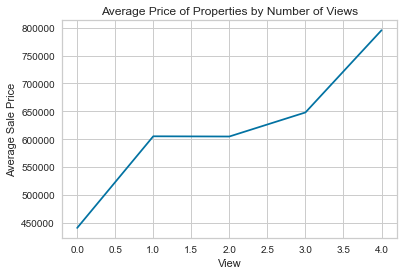

In [41]:
plt.plot(df1_v)
plt.title('Average Price of Properties by Number of Views')
plt.ylabel('Average Sale Price')
plt.xlabel('View')

Text(0.5, 0, 'View')

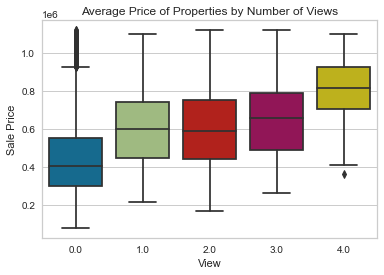

In [42]:
sns.boxplot(x= 'view', y= 'price', data= df1)
plt.title('Average Price of Properties by Number of Views')
plt.ylabel('Sale Price')
plt.xlabel('View')

Overall, the analysis shows that the housing prices increase when more groups of people get the tour. On average, houses with the most number of viewings were sold at a price $354,748 more than houses with 0 views. 

### Question 3: Does the King County grading system affect the housing price? 

In [43]:
df1_g = df1.groupby('grade')['price'].mean().round(2)
df1_g

grade
4    206,300.00000
5    237,756.98000
6    301,922.08000
7    399,963.84000
8    518,085.16000
9    668,319.31000
10   780,199.55000
11   930,000.00000
Name: price, dtype: float64

''

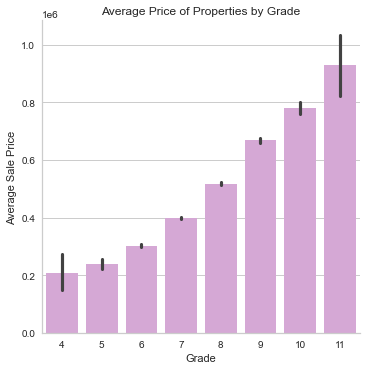

In [44]:
sns.catplot(x="grade", y="price", kind="bar", data=df1, color= 'plum')
plt.title('Average Price of Properties by Grade')
plt.xlabel('Grade')
plt.ylabel('Average Sale Price')
;

It is very evident that housing prices increase with higher grades. Therefore, we should consider acquiring properties with better grade if possible.

## Model 1

For the first iteration, I wanted to run the model with all the features.

In [45]:
X = df1.drop('price', axis= 1)
y = df1['price']

In [46]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = 0.20, random_state = 42)

                Coefficient
bedrooms       -7,790.81259
bathrooms      10,297.68054
sqft_living    37,239.71924
sqft_lot       -8,221.70420
floors          4,340.19906
waterfront      7,135.44931
view           20,265.66602
condition      18,621.51280
grade          66,289.92328
sqft_above     20,830.27470
basement_yn    11,739.11296
yr_built      -58,225.14979
renovated_yn    5,957.50550
zipcode       -14,516.29002
lat            74,700.11246
long             -998.66784
sqft_living15  24,650.78216
sqft_lot15    -18,927.32739
----------
Intercept: 451674.98460365983
----------
Train RMSE: 109024.09560009089
Test RMSE: 107925.92005813513
Train R2: 0.6724085454244642
Test R2: 0.6877104582982557


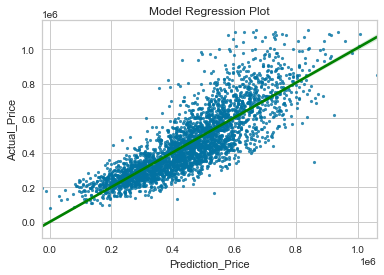

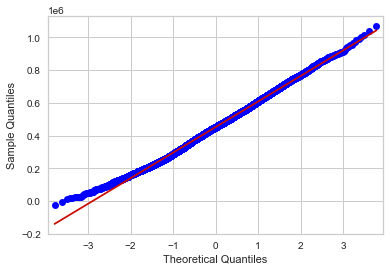

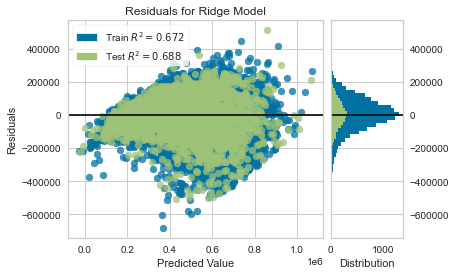

In [47]:
linear_model(X_train1,y_train1,X_test1,y_test1)

While our Q-Q plot and homoscedasticity plot are not perfect, they are not too terrible either. Given that this is the first iteration, it is reasonable that the model accounts for between 67%-69% of the variance. We will use this model as a baseline model to evaluate the other models moving forward

## Model 2
For a real estate company, it is not only important to have a strong list of properties but also to understand what would attract the buyers. With that in mind, I selected features that would matter to me when buying a house. Those includes number of bedrooms and bathrooms, size of the property, basement (Y/N), when it was built, renovated (Y/N), and the neighborhood.

In [48]:
df2 = df1.drop(['floors','waterfront','view','grade','lat','long','sqft_living15','sqft_lot15'], 
               axis =1)
df2

,price,bedrooms,bathrooms,sqft_living,sqft_lot,condition,sqft_above,basement_yn,yr_built,renovated_yn,zipcode
0,"221,900.00000",3,1.00000,1180,5650,3,1180,0.00000,1955,0.00000,98178
1,"538,000.00000",3,2.25000,2570,7242,3,2170,1.00000,1951,1.00000,98125
2,"180,000.00000",2,1.00000,770,10000,3,770,0.00000,1933,0.00000,98028
3,"604,000.00000",4,3.00000,1960,5000,5,1050,1.00000,1965,0.00000,98136
4,"510,000.00000",3,2.00000,1680,8080,3,1680,0.00000,1987,0.00000,98074
...,...,...,...,...,...,...,...,...,...,...,...
21592,"360,000.00000",3,2.50000,1530,1131,3,1530,0.00000,2009,0.00000,98103
21593,"400,000.00000",4,2.50000,2310,5813,3,2310,0.00000,2014,0.00000,98146
21594,"402,101.00000",2,0.75000,1020,1350,3,1020,0.00000,2009,0.00000,98144
21595,"400,000.00000",3,2.50000,1600,2388,3,1600,0.00000,2004,0.00000,98027


In [49]:
X = df2.drop('price', axis= 1)
y = df2['price']

In [50]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size = 0.20, random_state = 42)

               Coefficient
bedrooms     -26,020.73859
bathrooms     27,001.34453
sqft_living   74,482.69700
sqft_lot     -31,370.75051
condition     12,626.27022
sqft_above    53,702.67263
basement_yn   25,923.44647
yr_built     -59,173.03485
renovated_yn   5,347.30675
zipcode        6,310.40012
----------
Intercept: 451674.9846036579
----------
Train RMSE: 146853.64201725935
Test RMSE: 146907.57876606
Train R2: 0.4056298065437628
Test R2: 0.4213788247103898


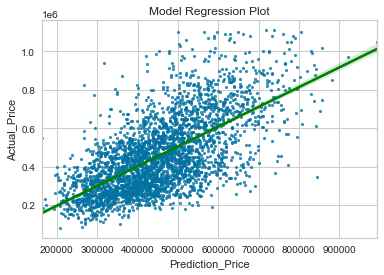

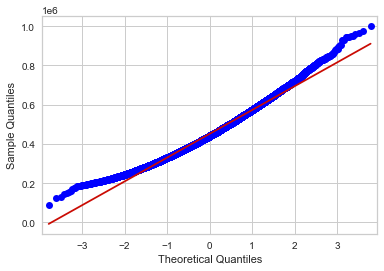

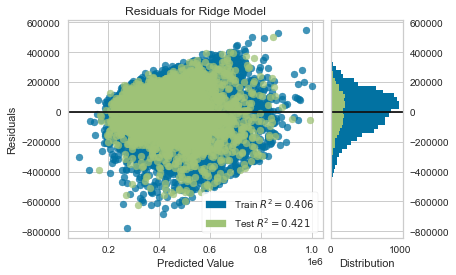

In [51]:
linear_model(X_train2,y_train2,X_test2,y_test2)

After hand-picking some of the features, Q-Q plot looks slightly worse but the homoscedasticty looks similar.Moreover,  this model is not so strong compared to the Model 1 when evaluating the R squared values. Therefore we will not use this model.

## Model 3

For the next model, let's apply feature engineering on `zipcode` column using One Hot Encoding. There are some other categorical varialbes in our dataset, but we will only focus on `zipcode` column as the other variables are ordinal. 

In [52]:
# One Hot Encode zipcodes column
encoder = OneHotEncoder(drop='first',sparse=False)
encoder.fit(df1[['zipcode']])

ohe_vars = encoder.transform(df1[['zipcode']])

df1_ohe = pd.DataFrame(ohe_vars,columns=encoder.get_feature_names(['zipcode']),
                      index=df1.index)
df1_ohe

,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [53]:
df1_ohe.columns

Index(['zipcode_98002', 'zipcode_98003', 'zipcode_98004', 'zipcode_98005',
       'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010',
       'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98022',
       'zipcode_98023', 'zipcode_98024', 'zipcode_98027', 'zipcode_98028',
       'zipcode_98029', 'zipcode_98030', 'zipcode_98031', 'zipcode_98032',
       'zipcode_98033', 'zipcode_98034', 'zipcode_98038', 'zipcode_98039',
       'zipcode_98040', 'zipcode_98042', 'zipcode_98045', 'zipcode_98052',
       'zipcode_98053', 'zipcode_98055', 'zipcode_98056', 'zipcode_98058',
       'zipcode_98059', 'zipcode_98065', 'zipcode_98070', 'zipcode_98072',
       'zipcode_98074', 'zipcode_98075', 'zipcode_98077', 'zipcode_98092',
       'zipcode_98102', 'zipcode_98103', 'zipcode_98105', 'zipcode_98106',
       'zipcode_98107', 'zipcode_98108', 'zipcode_98109', 'zipcode_98112',
       'zipcode_98115', 'zipcode_98116', 'zipcode_98117', 'zipcode_98118',
       'zipcode_98119', '

In [54]:
# Join One Hot Encoded dataframe with original dataframe and drop
# original zipcodes column
df3 = pd.concat([df1.drop('zipcode',axis=1),df1_ohe],axis=1)
df3

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,basement_yn,yr_built,renovated_yn,lat,long,sqft_living15,sqft_lot15,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,"221,900.00000",3,1.00000,1180,5650,1.00000,0.00000,0.00000,3,7,1180,0.00000,1955,0.00000,47.51120,-122.25700,1340,5650,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
1,"538,000.00000",3,2.25000,2570,7242,2.00000,0.00000,0.00000,3,7,2170,1.00000,1951,1.00000,47.72100,-122.31900,1690,7639,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,"180,000.00000",2,1.00000,770,10000,1.00000,0.00000,0.00000,3,6,770,0.00000,1933,0.00000,47.73790,-122.23300,2720,8062,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,"604,000.00000",4,3.00000,1960,5000,1.00000,0.00000,0.00000,5,7,1050,1.00000,1965,0.00000,47.52080,-122.39300,1360,5000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,"510,000.00000",3,2.00000,1680,8080,1.00000,0.00000,0.00000,3,8,1680,0.00000,1987,0.00000,47.61680,-122.04500,1800,7503,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00

In [55]:
X = df3.drop('price', axis= 1)
y = df3['price']

In [56]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size = 0.20, random_state = 42)

               Coefficient
bedrooms      -2,074.93759
bathrooms      8,334.25106
sqft_living   40,287.85422
sqft_lot       4,203.49851
floors        -8,130.04906
...                    ...
zipcode_98177 20,795.49582
zipcode_98178  6,063.49937
zipcode_98188  3,219.24197
zipcode_98198  3,018.32765
zipcode_98199 43,351.13812

[86 rows x 1 columns]
----------
Intercept: 451674.9846036584
----------
Train RMSE: 78833.16336370591
Test RMSE: 79272.46285989606
Train R2: 0.8287204603794756
Test R2: 0.8315191195488834


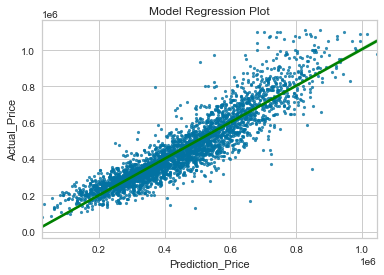

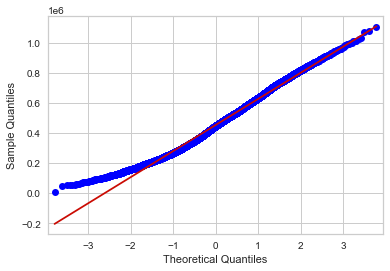

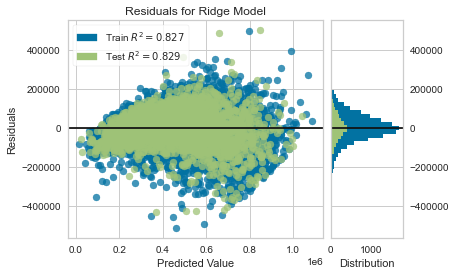

In [57]:
linear_model(X_train3, y_train3, X_test3, y_test3)

## Model 4
Since Model 3 with One Hot Encoding worked very well, I wanted to re-visit the selected features that were used in Model 2 and apply the selection for the next model.

In [58]:
df4 = df3.drop(['floors','waterfront','view','grade','lat','long','sqft_living15','sqft_lot15'],
               axis =1)
df4

,price,bedrooms,bathrooms,sqft_living,sqft_lot,condition,sqft_above,basement_yn,yr_built,renovated_yn,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,"221,900.00000",3,1.00000,1180,5650,3,1180,0.00000,1955,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
1,"538,000.00000",3,2.25000,2570,7242,3,2170,1.00000,1951,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,"180,000.00000",2,1.00000,770,10000,3,770,0.00000,1933,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,"604,000.00000",4,3.00000,1960,5000,5,1050,1.00000,1965,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,"510,000.00000",3,2.00000,1680,8080,3,1680,0.00000,1987,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0

In [59]:
X = df4.drop('price', axis= 1)
y = df4['price']

In [60]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size = 0.20, random_state = 42)

               Coefficient
bedrooms      -7,817.01510
bathrooms     10,228.13027
sqft_living   61,857.21140
sqft_lot      12,395.47999
condition     15,266.30083
...                    ...
zipcode_98177 24,786.94415
zipcode_98178  8,746.52548
zipcode_98188  3,810.84595
zipcode_98198  6,198.81412
zipcode_98199 49,142.08428

[78 rows x 1 columns]
----------
Intercept: 451674.98460365855
----------
Train RMSE: 86779.57667434774
Test RMSE: 86934.82756743295
Train R2: 0.7924500498272671
Test R2: 0.7973747726655287


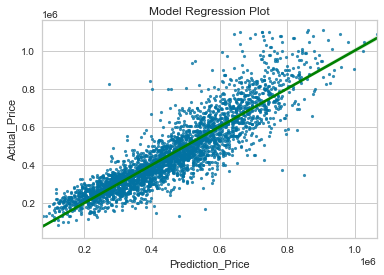

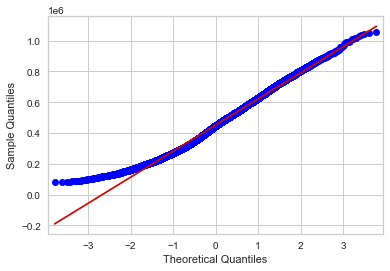

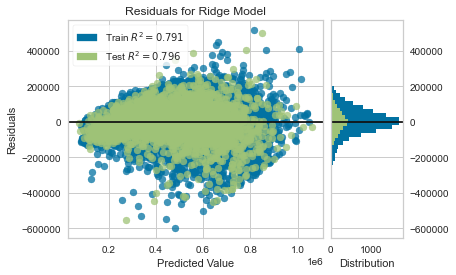

In [61]:
linear_model(X_train4,y_train4,X_test4,y_test4)

Given that this model also uses selected features, it is a pretty strong model compared to the Model 2. However, Model 3 still shows the best result.

## Model 5
For our last model, we will use the log transormation on the continuous variables.

In [62]:
# Create a temporary table to select continuous variable which we will run log trasformation on.
temp = df3.copy()

In [63]:
temp.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'basement_yn',
       'yr_built', 'renovated_yn', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'zipcode_98002', 'zipcode_98003', 'zipcode_98004',
       'zipcode_98005', 'zipcode_98006', 'zipcode_98007', 'zipcode_98008',
       'zipcode_98010', 'zipcode_98011', 'zipcode_98014', 'zipcode_98019',
       'zipcode_98022', 'zipcode_98023', 'zipcode_98024', 'zipcode_98027',
       'zipcode_98028', 'zipcode_98029', 'zipcode_98030', 'zipcode_98031',
       'zipcode_98032', 'zipcode_98033', 'zipcode_98034', 'zipcode_98038',
       'zipcode_98039', 'zipcode_98040', 'zipcode_98042', 'zipcode_98045',
       'zipcode_98052', 'zipcode_98053', 'zipcode_98055', 'zipcode_98056',
       'zipcode_98058', 'zipcode_98059', 'zipcode_98065', 'zipcode_98070',
       'zipcode_98072', 'zipcode_98074', 'zipcode_98075', 'zipcode_98077',
       'zipcode_98092', 'zip

In [64]:
# Select the continuous variables
con = ['sqft_living','sqft_lot','yr_built','sqft_living15','sqft_lot15']

df_con = temp[con]

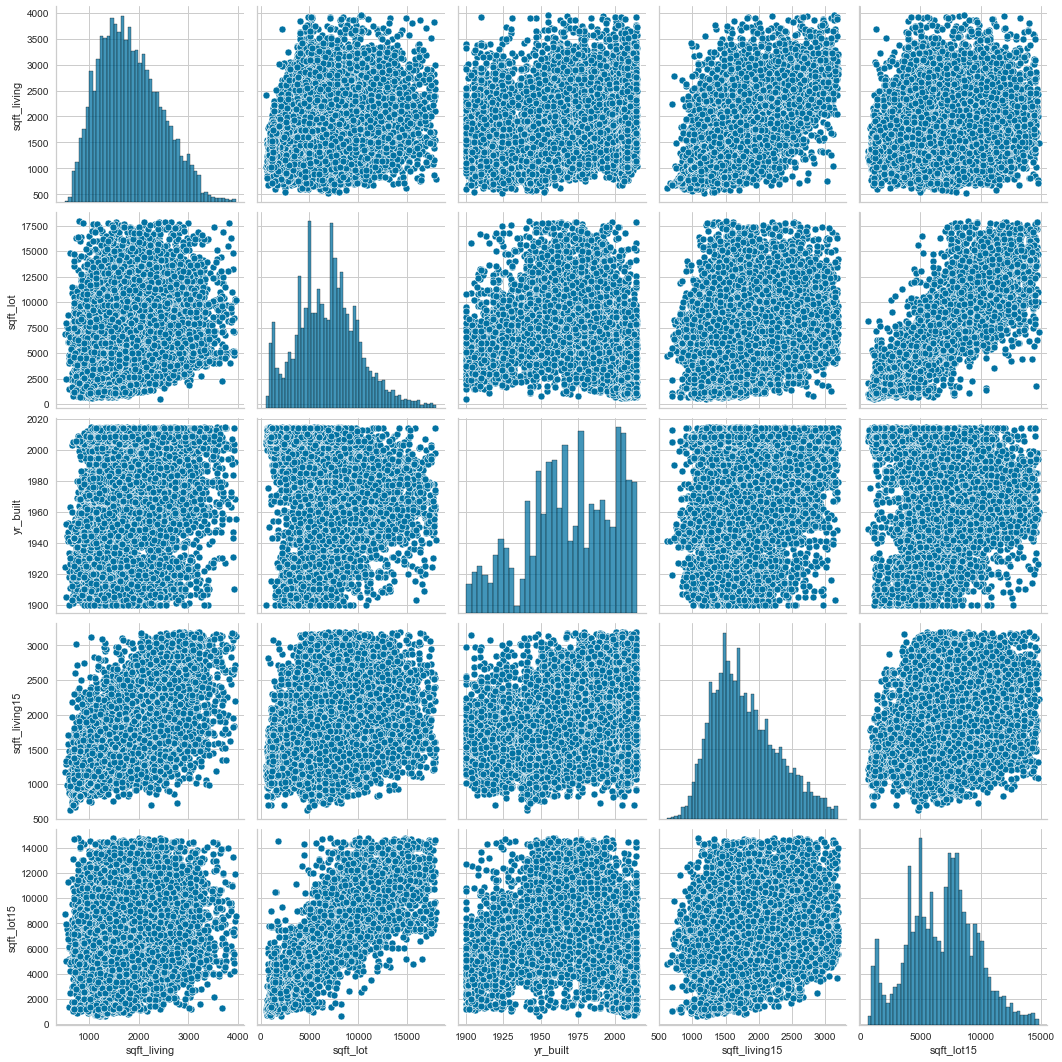

In [65]:
# Create a pairplot to check variable distributions
cont_pp = sns.pairplot(df_con, height = 3)

In [66]:
# Run the log transformation on the selected continuous variables
log_names = [f'{column}_log' for column in df_con.columns]

df_con_log = np.log(df_con)
df_con_log.columns = log_names

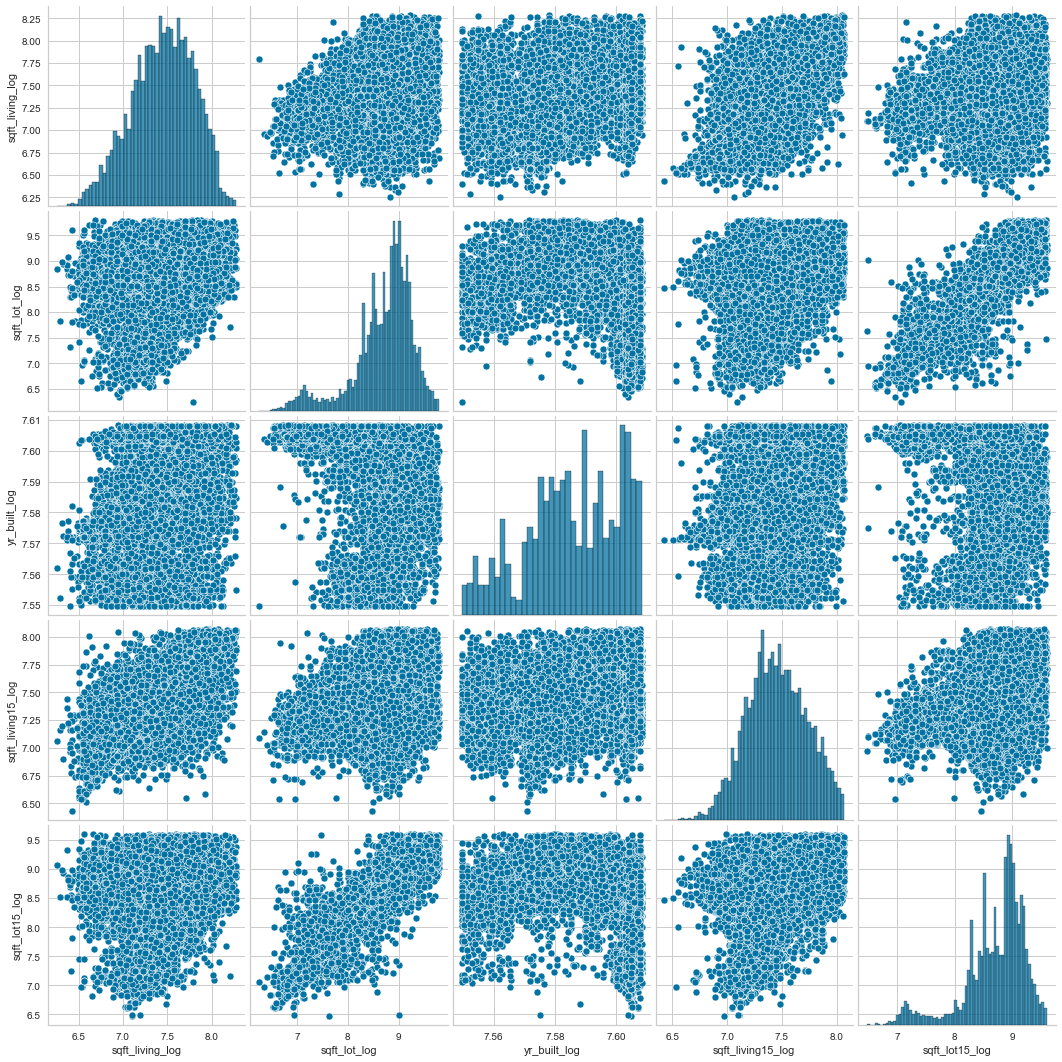

In [67]:
# Run another pairplot after the log transformation
cont_pp2 = sns.pairplot(df_con_log, height= 3)

In [68]:
# Add the log-transformed columns into a DataFrame
df6 = pd.concat([df_con_log, temp], axis= 1)
df6.head()

,sqft_living_log,sqft_lot_log,yr_built_log,sqft_living15_log,sqft_lot15_log,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,basement_yn,yr_built,renovated_yn,lat,long,sqft_living15,sqft_lot15,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,7.07327,8.63941,7.57815,7.20042,8.63941,"221,900.00000",3,1.00000,1180,5650,1.00000,0.00000,0.00000,3,7,1180,0.00000,1955,0.00000,47.51120,-122.25700,1340,5650,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
1,7.85166,8.88765,7.57610,7.43248,8.94102,"538,000.00000",3,2.25000,2570,7242,2.00000,0.00000,0.00000,3,7,2170,1.00000,1951,1.00000,47.72100,-122.31900,1690,7639,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,6.64639,9.21034,7.56683,7.90839,8.99492,"180,000.00000",2,1.00000,770,10000,1.00000,0.00000,0.00000,3,6,770,0.00000,1933,0.00000,47.73790,-122.23300,2720,8062,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,7.58070,8.51719,7.58325,7.21524,8.51719,"604,000.00000",4,3.00000,1960,5000,1.00000,0.00000,0.00000,5,7,1050,1.00000,1965,0.00000,47.52080,-122.39300,1360,5000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.0

In [69]:
# Drop the original columns that we ran log transformation on
df6.drop(columns= ['sqft_living','sqft_lot','yr_built','sqft_living15','sqft_lot15'], inplace= True)

In [70]:
X = df6.drop('price', axis= 1)
y = df6['price']

In [71]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size = 0.20, random_state = 42)

                    Coefficient
sqft_living_log    20,407.16772
sqft_lot_log       17,207.21308
yr_built_log      -12,621.71500
sqft_living15_log  12,073.59906
sqft_lot15_log        731.08688
...                         ...
zipcode_98177      22,548.70886
zipcode_98178       7,746.49565
zipcode_98188       3,809.98980
zipcode_98198       3,723.43312
zipcode_98199      46,215.77079

[86 rows x 1 columns]
----------
Intercept: 451674.98460365867
----------
Train RMSE: 79044.62152417332
Test RMSE: 79550.4463356079
Train R2: 0.8278003645690246
Test R2: 0.8303354293582601


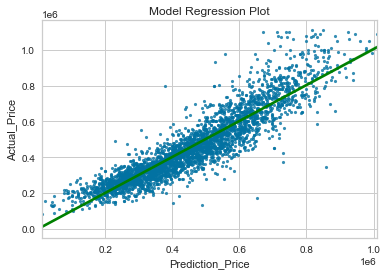

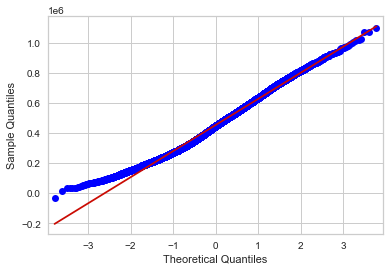

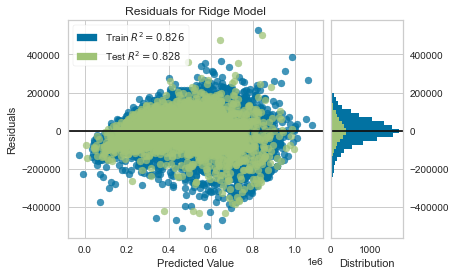

In [72]:
linear_model(X_train5, y_train5, X_test5, y_test5)

## Conclusion
Our winning model (Model 3) has an R squared values of 0.83, indicating that the model is capable of explaining 83% of the variability in a property's price. However, I want to point out that model 5 is also a very strong when all things considered (R squared values, Q-Q plot, and homoscedasticity plot). From this analysis, we can conclude that `sqft_living`, `grade`, and `sqft_above` are features that have strong relationship with the target variable (`price`). Model 3 combined with EDA performed in the above led to below three recommendations.

**1. It's all about the size!** Expectedly, our analysis shows that the space of a property matters the most and will add the most value to the house sales price. While having a variety of listings to satisfy different buyers, it would be the best to prioritize buyers looking for a house for their family.

**2. Larger living space apart from basement!** While the overall size of space matters, it is more imperative to have larger space above the ground.

**3. Secure waterfront properties when available!** While there are not that many, our analysis shows that a waterfront property can be worth $344,597 more than an inland property on average. There were only 146 waterfront properties to begin with in the data set, which consists of 0.80% of the total transactions. Given that acquiring a waterfront property is quite rare and a waterfront property can be worth a lot more, I recommend the team to prioritize acquiring waterfront properties to their listings. 

**4. Advertise and show the properties to many people!** It was very evident from our analysis that the housing price has a direct relationship with the number of viewings to potential buyers. I highly recommend advertising each property if possible, and creating a small "competition" will definitely help.

**5. Grading matters!** Higher grades yield higher housing prices. I recommend the team to avoid including low grade properties as the sales price increases with higher grade. This will provide the team with opportunities to close deals in their/seller's favor.